# Methodology

This section will discuss the methodology surrounding the 2012-2015 data. 

In [1]:
import pandas as pd
from itertools import takewhile
import plotly.graph_objects as go
import plotly.express as px
import base64
import numpy as np
import glob
import xarray as xr
import matplotlib.pyplot as plt
from numpy import loadtxt

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from fig_mods.nextstep import areagrid

In [2]:
ds_flux_old = xr.open_dataset("data/flux_data.nc")

## Set the longitude and latitude to only include the UK;

min_lon = -12
min_lat = 48
max_lon = 5 
max_lat = 62 

ds_flux_old = ds_flux_old.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

In [3]:
ds_flux = xr.open_dataset("data/flux_MetOffice-InTEM_ch4_MHD_TAC_RGL_TTA_BSD_HFD_CBW_WAO_JFJ_CMN_ZEP_TRN_LUT_2012-2021_Dec2022.nc")

## Set the longitude and latitude to only include the UK;

min_lon = -12
min_lat = 50

max_lon = 2 
max_lat = 62 

ds_flux = ds_flux.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

In [4]:
ds_flux

<xarray.Dataset>
Dimensions:             (time: 120, lon: 39, lat: 52, country: 1)
Coordinates:
  * time                (time) datetime64[ns] 2012-01-01 ... 2021-12-01
  * lon                 (lon) float32 -11.66 -11.31 -10.96 ... 1.012 1.364 1.716
  * lat                 (lat) float32 50.04 50.28 50.51 ... 61.51 61.74 61.98
Dimensions without coordinates: country
Data variables:
    country_name        (country) |S2 ...
    flux_mean           (lat, lon, time) float32 ...
    flux_std            (lat, lon, time) float32 ...
    flux_prior          (lat, lon, time) float32 ...
    flux_std_prior      (lat, lon, time) float32 ...
    country_post_mean   (country, time) float32 ...
    country_post_std    (country, time) float32 ...
    country_prior_mean  (country, time) float32 ...
    country_prior_std   (country, time) float32 ...
Attributes:
    history:           Created on 2022-12-06 08:38:46 by A. J. Manning
    molecular_weight:  16.0

In [5]:
lat = np.arange(50.041, 61.975002, 0.234)
lon = np.arange(-11.66, 1.716001, 0.352)
area = areagrid(lat, lon)
#area

In [6]:
## Create a function to produce a mean flux reading for each year;

def weighted_temporal_mean(ds, var):

    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")
    
    return obs_sum / ones_out

In [7]:
Intem_new_year = weighted_temporal_mean(ds_flux, "flux_prior")
Intem2012 = Intem_new_year[dict(time=0)] * area
Intem2013 = Intem_new_year[dict(time=1)] * area
Intem2014 = Intem_new_year[dict(time=2)] * area
Intem2015 = Intem_new_year[dict(time=3)] * area

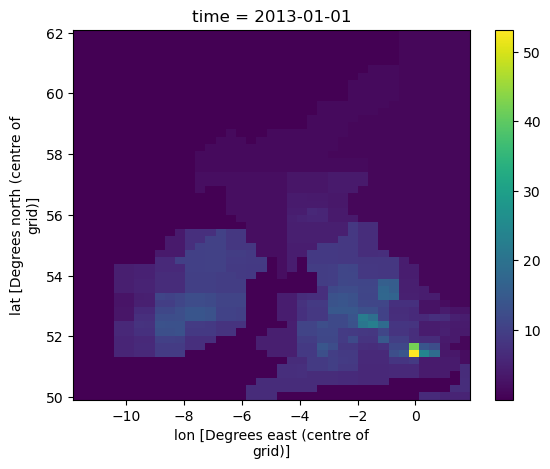

In [8]:
Intem2013.plot()

In [9]:
def read_invent_ch4_old(year, species):
    import pandas as pd
    from itertools import takewhile
    import plotly.graph_objects as go
    import base64
    import numpy as np
    import glob
    import xarray as xr
    
    csv = glob.glob(f"data/ch4-ukghg-{species}_EUROPE_{year}.nc")
    
    flux = xr.open_dataset(csv[0])
    
    min_lon = -12
    min_lat = 48
    max_lon = 5 
    max_lat = 62 
    
    cropped_ds = flux.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
    
    cropped_ds = cropped_ds * area
    
    return cropped_ds

In [10]:
def read_invent_ch4(year, species):
    import pandas as pd
    from itertools import takewhile
    import plotly.graph_objects as go
    import base64
    import numpy as np
    import glob
    import xarray as xr
    
    csv = glob.glob(f"data/ch4-edgarv7-ukghg-yearly/ch4-edgarv7-ukghg-europe-{year}/ch4-edgarv7-ukghg-{species}_EUROPE_{year}.nc")
    
    flux = xr.open_dataset(csv[0])
    
    min_lon = -12
    min_lat = 50

    max_lon = 2 
    max_lat = 62 
    
    cropped_ds = flux.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
    
    cropped_ds1 = cropped_ds[dict(time=0)] * area
        
    return cropped_ds1

In [11]:
test2012 = read_invent_ch4("2012", "total")
test2012

<xarray.Dataset>
Dimensions:  (lat: 52, lon: 39)
Coordinates:
  * lat      (lat) float32 50.04 50.28 50.51 50.74 ... 61.27 61.51 61.74 61.97
  * lon      (lon) float32 -11.66 -11.31 -10.96 -10.6 ... 0.66 1.012 1.364 1.716
    time     datetime64[ns] 2012-01-01
Data variables:
    flux     (lat, lon) float64 0.002021 0.002142 ... 0.0006935 0.0005155
Attributes:
    Processed by:   wz22079@bristol.ac.uk
    Processed on:   2022-12-08 14:59:17.769336+00:00
    title:          EDGAR with UK lat/lons replaced with UKGHG values, regrid...
    EDGAR sectors:  ['AGS', 'AWB', 'ENF', 'MNM', 'RCO', 'ENE', 'IND', 'CHE', ...
    UKGHG sectors:  total

In [12]:
def plot_sector(year):
    
    fig, axs = plt.subplots(4, 3, figsize = (13, 13), subplot_kw={'projection':cartopy.crs.PlateCarree()})
    
    species = ["total", "agric", "domcom", "energyprod", "indcom", "indproc", "offshore", "othertrans", "roadtrans", "waste"]
    
    fontsizes = {"title":10, "labels": 10, "axis":10}
    
    for name, ax in zip(species, axs.flatten()):
        
        a = read_invent_ch4(year, name)
        b = read_invent_ch4(year, "total")
        
        fract = 100*(a.flux / b.flux)
    
        fract = np.clip(fract, 0, 100)
        
        test = fract.reindex_like(Intem2012, method='nearest', tolerance=0.01)
        
        if year == "2012":
            data = test/100 * Intem2012
            x = 'Reds'
        elif year == "2013":
            data = test/100 * Intem2013
            x = 'Blues'
        elif year == "2014":
            data = test/100 * Intem2014
            x = 'Greens'
        elif year == "2015":
            data = test/100 * Intem2015
            x = 'Purples'
                
        a = ax.pcolormesh(data.lon, data.lat, data, cmap=plt.cm.get_cmap(x))
        ax.set_extent([-12,3, 49.9,60], crs=cartopy.crs.PlateCarree())        
        ax.coastlines(resolution='50m', color='black', linewidth=1)
        
        ax.set_xticks([-12, -8, -4, 0], crs=cartopy.crs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.1f',
                                    degree_symbol='',
                                    dateline_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)        
        # set y-ticks for the plot, and format          
        ax.set_yticks([50, 54, 58], crs=cartopy.crs.PlateCarree())
        lat_formatter = LatitudeFormatter(number_format='.1f',  degree_symbol='',)
        ax.yaxis.set_major_formatter(lat_formatter)             
        ax.tick_params(axis='both', which='major', labelsize=fontsizes["axis"]) 
        
        fig.colorbar(a, ax=ax, pad=0.05, shrink=0.7)
        
        ax.set_title("2013" +"\n"+ name, fontsize = fontsizes["title"])
        ax.set_ylabel("Latitude (degrees)", fontsize = fontsizes["labels"])
        ax.set_xlabel("Longitude (degrees)", fontsize = fontsizes["labels"])
        
    fig.tight_layout()

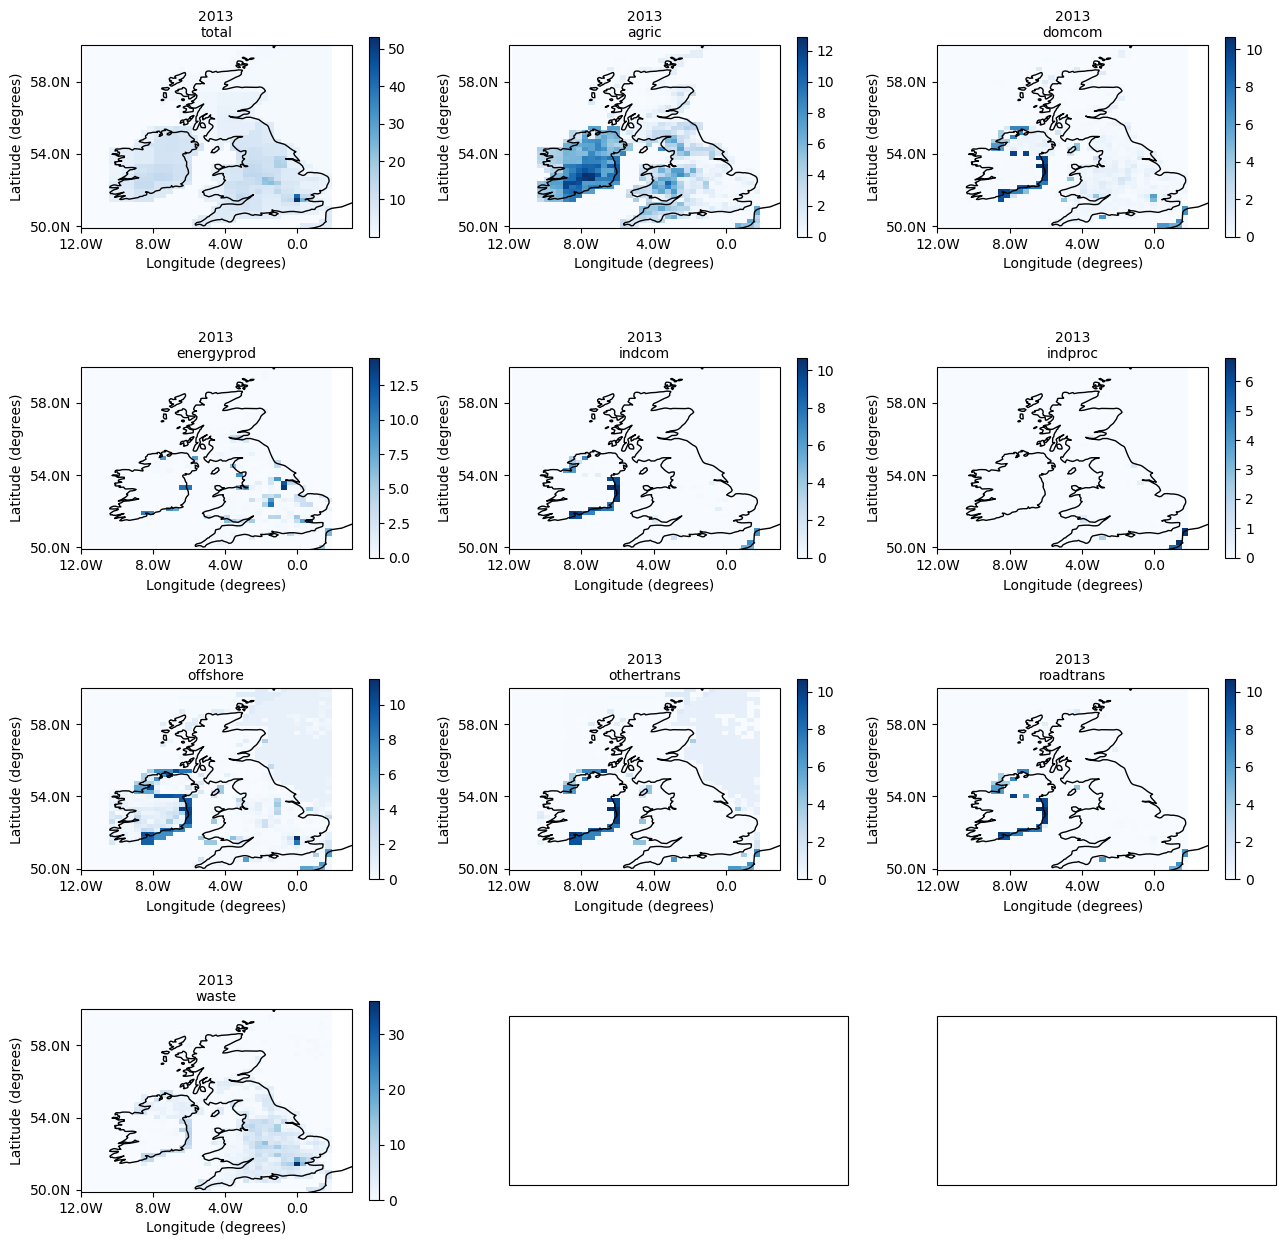

In [13]:
plot_sector("2013")

In [14]:
def plot_sector_perc(year):
    
    fig, axs = plt.subplots(4, 3, figsize = (13, 13), subplot_kw={'projection':cartopy.crs.PlateCarree()})
    
    species = ["total", "agric", "domcom", "energyprod", "indcom", "indproc", "offshore", "othertrans", "roadtrans", "waste"]
    
    fontsizes = {"title":10, "labels": 10, "axis":10}
    
    for name, ax in zip(species, axs.flatten()):
        
        a = read_invent_ch4(year, name)
        b = read_invent_ch4(year, "total")
        

        fract = 100*(a.flux / b.flux)

        fract = np.clip(fract, 0, 100)

        test = fract.reindex_like(Intem2012, method='nearest', tolerance=0.01)
        
        if year == "2012":
            test1 = test * Intem2012
            data = test1 / Intem2012 #* 100
            x = 'Reds'
        elif year == "2013":
            test1 = test * Intem2013
            data = test1 / Intem2013 #* 100
            x = 'Blues'
        elif year == "2014":
            test1 = test * Intem2014
            data = test1 / Intem2014 #* 100
            x = 'Greens'
        elif year == "2015":
            test1 = test * Intem2015
            data = test1 / Intem2015 #* 100
            x = 'Purples'
                
        a = ax.pcolormesh(data.lon, data.lat, data, cmap=plt.cm.get_cmap(x))
        ax.set_extent([-12,3, 49.9,60], crs=cartopy.crs.PlateCarree())        
        ax.coastlines(resolution='50m', color='black', linewidth=1)
        
        ax.set_xticks([-12, -8, -4, 0], crs=cartopy.crs.PlateCarree())
        lon_formatter = LongitudeFormatter(number_format='.1f',
                                    degree_symbol='',
                                    dateline_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)        
        # set y-ticks for the plot, and format          
        ax.set_yticks([50, 54, 58], crs=cartopy.crs.PlateCarree())
        lat_formatter = LatitudeFormatter(number_format='.1f',  degree_symbol='',)
        ax.yaxis.set_major_formatter(lat_formatter)             
        ax.tick_params(axis='both', which='major', labelsize=fontsizes["axis"]) 
    
        ax.set_title(year +"\n"+ name, fontsize = fontsizes["title"])
        fig.colorbar(a, ax=ax, pad=0.05, shrink=0.7)
        ax.set_ylabel("Latitude (degrees)", fontsize = fontsizes["labels"])
        ax.set_xlabel("Longitude (degrees)", fontsize = fontsizes["labels"])
        
    fig.tight_layout()

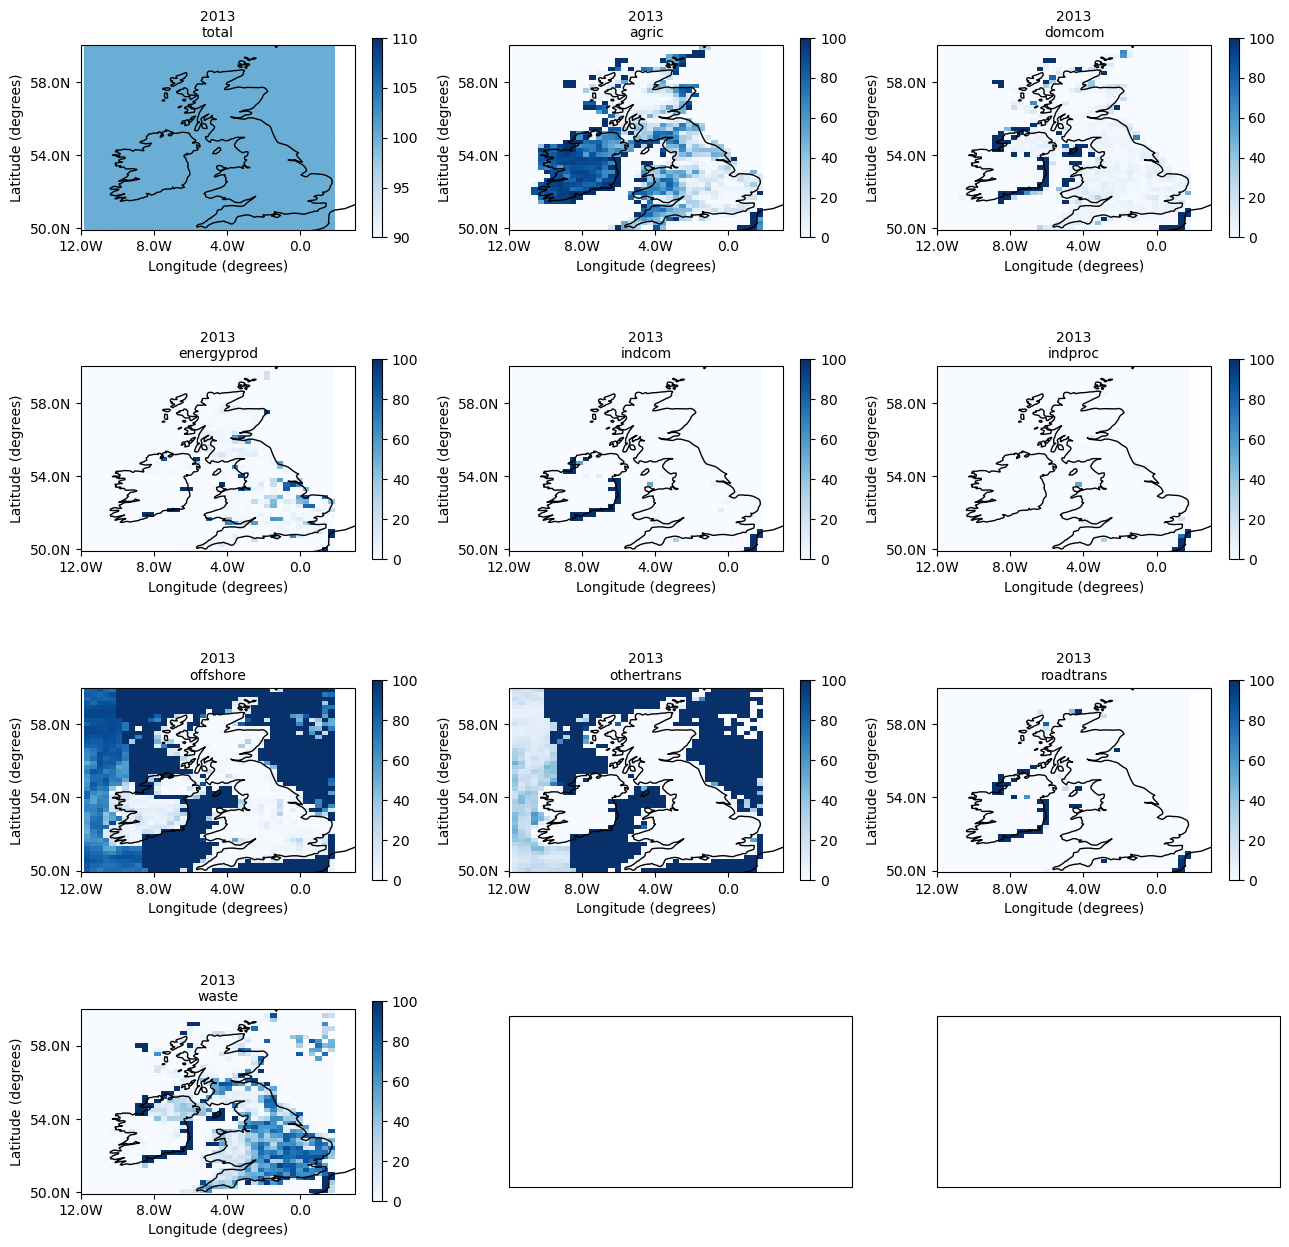

In [15]:
plot_sector_perc("2013")